<h1  align="center"> Sentiment Analysis and classification on IMDB dataset </h1>

The following steps are followed to perform sentiment analysis on the given dataset:

1. **Data Cleaning**
2. **Tokenization**
3. **Lemmatization/Stemming**
4. **POS Tagging**
5. **Word Embeddings**
6. **Vectorization**
7. **Training a model**
8. **Inference**

## About the dataset

The IMDB Large Movie Review Dataset is a benchmark collection of 50,000 highly polar movie reviews used extensively for binary sentiment classification in Natural Language Processing (NLP). It is evenly split into 25,000 samples for training and 25,000 for testing, with a balanced distribution of 50% positive and 50% negative labels. To ensure clear sentiment signals, the dataset exclusively includes reviews with scores of ≤4/10 (negative) or ≥7/10 (positive), omitting neutral feedback. Because it captures authentic human expression—complete with varying syntax and informal language—it remains a primary standard for training and evaluating the accuracy of machine learning models and neural networks.

### Loading requried data and libraries

In [1]:
import os
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import regex as re
from string import punctuation
import math

import nltk
nltk.download("omw-1.4")
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [ ]:
data = pd.read_csv('../data/IMDB Dataset.csv')

### Looking into the data

In [3]:
data.head(20)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [4]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

### Data Cleaning


The following operations are performed:
1. Removing Null values
2. Removing duplicate values
3. Lowering text to normalize the text
4. Removing Punctuations from string. (Punctuations - !"#$\%&'()*+,-\./:;<=>?@[\\]^_`{|}~)
5. Removing stopwords from string. Stopwords are words which are present in abundance in string and can be tricky for some models to learn from the words which have higher impact. For example "in", "at", "the", "a",etc.


In [ ]:
data[data['review'].duplicated() == True]

,review,sentiment
27528,This is yet another pseudointellectual lets ma...,negative


In [14]:
data.drop_duplicates(subset='review', inplace=True)

In [15]:
data.describe()

,review,sentiment
count,49581,49581
unique,49581,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


In [16]:
def remove_punc(series):
    temp = re.sub(f'[{punctuation}]', '', series)
    temp = re.sub(' br br ',' ', temp)
    temp = re.sub(' n ',' ', temp)
    return temp

data['review'] = data['review'].apply(remove_punc)

In [17]:
data[['review']].head()

,review
0,One of the other reviewers has mentioned that ...
1,A wonderful little production The filming tech...
2,I thought this was a wonderful way to spend ti...
3,Basically theres a family where a little boy J...
4,Petter Matteis Love in the Time of Money is a ...


In [18]:
def remove_stop(series):
    return ' '.join([x.lower() for x in series.split(' ') if x.lower() not in STOPWORDS])

data['review'] = data['review'].apply(remove_stop)

In [19]:
data[['review']]

,review
0,one reviewers mentioned watching 1 oz episode ...
1,wonderful little production filming technique ...
2,thought wonderful way spend time hot summer we...
3,basically theres family little boy jake thinks...
4,petter matteis love time money visually stunni...
...,...
49995,thought movie right good job wasnt creative or...
49996,bad plot bad dialogue bad acting idiotic direc...
49997,catholic taught parochial elementary schools n...
49998,im going disagree previous comment side maltin...


## Tokenization

Here, we will be tokenizing using word tokenizer from nltk (Natural Language tool kit) package.

In [20]:
def tokenize(series):
    return word_tokenize(series)

data['tokens'] = data['review'].apply(tokenize)

In [21]:
def get_len(series):
    return len(series)

data['token_len'] = data['tokens'].apply(get_len)

In [ ]:
data[['tokens','token_len']].head()

,tokens,token_len
0,"[one, reviewers, mentioned, watching, 1, oz, e...",167
1,"[wonderful, little, production, filming, techn...",84
2,"[thought, wonderful, way, spend, time, hot, su...",88
3,"[basically, theres, family, little, boy, jake,...",71
4,"[petter, matteis, love, time, money, visually,...",128


In [23]:
data.describe()

,token_len
count,49581.000000
mean,120.137069
std,90.717418
min,3.000000
25%,64.000000
50%,89.000000
75%,146.000000
max,1432.000000


### Padding

In [24]:
MAX_LEN = math.ceil(data.describe().values[1])
print(MAX_LEN)

121


In [25]:
def pad_token(series):
    if len(series) < MAX_LEN:
        series.extend(['<END>']*(MAX_LEN-len(series)))
        return series
    else:
        return series[:MAX_LEN]

data['paded_tokens'] = data['tokens'].apply(pad_token)

In [26]:
print(data['paded_tokens'].values[10])

['phil', 'alien', 'one', 'quirky', 'films', 'humour', 'based', 'around', 'oddness', 'everything', 'rather', 'actual', 'punchlinesbr', 'br', 'first', 'odd', 'pretty', 'funny', 'movie', 'progressed', 'didnt', 'find', 'jokes', 'oddness', 'funny', 'anymorebr', 'br', 'low', 'budget', 'film', 'thats', 'never', 'problem', 'pretty', 'interesting', 'characters', 'eventually', 'lost', 'interestbr', 'br', 'imagine', 'film', 'appeal', 'stoner', 'currently', 'partakingbr', 'br', 'something', 'similar', 'better', 'try', 'brother', 'another', 'planet', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>

In [27]:
data[['tokens','paded_tokens']]

,tokens,paded_tokens
0,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, reviewers, mentioned, watching, 1, oz, e..."
1,"[wonderful, little, production, filming, techn...","[wonderful, little, production, filming, techn..."
2,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonderful, way, spend, time, hot, su..."
3,"[basically, theres, family, little, boy, jake,...","[basically, theres, family, little, boy, jake,..."
4,"[petter, matteis, love, time, money, visually,...","[petter, matteis, love, time, money, visually,..."
...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...","[thought, movie, right, good, job, wasnt, crea..."
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...","[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,"[catholic, taught, parochial, elementary, scho...","[catholic, taught, parochial, elementary, scho..."
49998,"[im, going, disagree, previous, comment, side,...","[im, going, disagree, previous, comment, side,..."


### Normalization

For grammatical reasons, documents are going to use different forms of a word, such as organize, organizes, and organizing. Additionally, there are families of derivationally related words with similar meanings, such as democracy, democratic, and democratization. In many situations, it seems as if it would be useful for a search for one of these words to return documents that contain another word in the set.

To cater the above situation the most common approaches are:

1. Lemmatizing
2. Stemming

The root word is called a stem in the stemming process, and it is called a lemma in the lemmatization process.

The goal of both stemming and lemmatization is to reduce forms of a word to a common base form.
for eg - running, ran, run all has a base form as 'run'

### Lemmatizing

Lemmatizing is the process of reducing words to their root forms such as mapping a group of words to the same lemma if the lemma itself is a valid word in the Language.

In [28]:
lemmatizer = WordNetLemmatizer()

In [29]:
def lemma(series):
    return [lemmatizer.lemmatize(word) for word in series]

data['lemma_tokens'] = data['paded_tokens'].apply(lemma)

In [30]:
data[['tokens','lemma_tokens']]

,tokens,lemma_tokens
0,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, reviewer, mentioned, watching, 1, oz, ep..."
1,"[wonderful, little, production, filming, techn...","[wonderful, little, production, filming, techn..."
2,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonderful, way, spend, time, hot, su..."
3,"[basically, theres, family, little, boy, jake,...","[basically, there, family, little, boy, jake, ..."
4,"[petter, matteis, love, time, money, visually,...","[petter, matteis, love, time, money, visually,..."
...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...","[thought, movie, right, good, job, wasnt, crea..."
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...","[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,"[catholic, taught, parochial, elementary, scho...","[catholic, taught, parochial, elementary, scho..."
49998,"[im, going, disagree, previous, comment, side,...","[im, going, disagree, previous, comment, side,..."


### Stemming

Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

In [31]:
stemmer = PorterStemmer()

In [32]:
def stem(series):
    return [stemmer.stem(word) for word in series]

data['stem_tokens'] = data['tokens'].apply(stem)

In [33]:
data[['tokens','stem_tokens']]

,tokens,stem_tokens
0,"[one, reviewers, mentioned, watching, 1, oz, e...","[one, review, mention, watch, 1, oz, episod, y..."
1,"[wonderful, little, production, filming, techn...","[wonder, littl, product, film, techniqu, unass..."
2,"[thought, wonderful, way, spend, time, hot, su...","[thought, wonder, way, spend, time, hot, summe..."
3,"[basically, theres, family, little, boy, jake,...","[basic, there, famili, littl, boy, jake, think..."
4,"[petter, matteis, love, time, money, visually,...","[petter, mattei, love, time, money, visual, st..."
...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...","[thought, movi, right, good, job, wasnt, creat..."
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...","[bad, plot, bad, dialogu, bad, act, idiot, dir..."
49997,"[catholic, taught, parochial, elementary, scho...","[cathol, taught, parochi, elementari, school, ..."
49998,"[im, going, disagree, previous, comment, side,...","[im, go, disagre, previou, comment, side, malt..."


### POS Tagging

Part of Speech (POS) tagging refers to classifying words in a sentence into their part of speech. 

Parts of speech are also known as word classes or lexical categories. The collection of tags used for a particular task is known as a tagset.

In [34]:
def pos_t(series):
    return nltk.pos_tag(series, tagset='universal')

data['pos_tag_tokens'] = data['tokens'].apply(pos_t)

In [36]:
data[['tokens','pos_tag_tokens']]

,tokens,pos_tag_tokens
0,"[one, reviewers, mentioned, watching, 1, oz, e...","[(one, NUM), (reviewers, NOUN), (mentioned, VE..."
1,"[wonderful, little, production, filming, techn...","[(wonderful, ADJ), (little, ADJ), (production,..."
2,"[thought, wonderful, way, spend, time, hot, su...","[(thought, VERB), (wonderful, ADJ), (way, NOUN..."
3,"[basically, theres, family, little, boy, jake,...","[(basically, ADV), (theres, NOUN), (family, NO..."
4,"[petter, matteis, love, time, money, visually,...","[(petter, NOUN), (matteis, ADV), (love, ADJ), ..."
...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...","[(thought, VERB), (movie, NOUN), (right, ADV),..."
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...","[(bad, ADJ), (plot, NOUN), (bad, ADJ), (dialog..."
49997,"[catholic, taught, parochial, elementary, scho...","[(catholic, ADJ), (taught, VERB), (parochial, ..."
49998,"[im, going, disagree, previous, comment, side,...","[(im, NOUN), (going, VERB), (disagree, ADJ), (..."


### Word Embeddings

In [37]:
unique_words = set()
for tokens in list(data['lemma_tokens'].values):
    unique_words.update(tokens)

In [38]:
print('Count of Unique words:', len(unique_words))

Count of Unique words: 142446


In [39]:
word2idx = {}
for word in unique_words:
    word2idx[word] = len(word2idx)
word2idx['<END>'] = len(word2idx)

In [40]:
word_embeddings = np.random.rand(len(word2idx),200)
with open('../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt', 'r') as embeds:
    embeddings = embeds.read()
    embeddings = embeddings.split('\n')[:-2]
    
for token_idx, token_embed in enumerate(embeddings):
    token = token_embed.split()[0]
    if token in word2idx:
        word_embeddings[word2idx[token]] = [float(val) for val in token_embed.split()[1:]]

In [ ]:
print(f'Word embeddings for word {list(word2idx.keys())[300]}:',word_embeddings[300])

Now these word embeddings can be used in NLP models

### Vecotrization

In [44]:
vectorizer = CountVectorizer()

In [45]:
vector_cl = vectorizer.fit_transform([' '.join(tok) for tok in list(data['lemma_tokens'].values)])

In [46]:
vector_cl.shape

(49581, 141851)

#### Vecotrizing the lables

In [47]:
def label_vec(series):
    return int(series=='positive')

data['sentiment'] = data['sentiment'].apply(label_vec)

In [48]:
data[['lemma_tokens', 'sentiment']].head()

,lemma_tokens,sentiment
0,"[one, reviewer, mentioned, watching, 1, oz, ep...",1
1,"[wonderful, little, production, filming, techn...",1
2,"[thought, wonderful, way, spend, time, hot, su...",1
3,"[basically, there, family, little, boy, jake, ...",0
4,"[petter, matteis, love, time, money, visually,...",1


### Identify and train Models

In [49]:
vector_cl_train_x, vector_cl_test_x, vector_cl_train_y, vector_cl_test_y = train_test_split(vector_cl, data['sentiment'].values, test_size=0.3, random_state=42)
print(vector_cl_train_x.shape,vector_cl_train_y.shape,vector_cl_test_x.shape,vector_cl_test_y.shape)

(34706, 141851) (34706,) (14875, 141851) (14875,)


In [53]:
log_reg = LogisticRegression(
    max_iter=2000,
    solver="liblinear"
).fit(vector_cl_train_x, vector_cl_train_y)

### Inference

In [55]:
pred = log_reg.predict(vector_cl_test_x)

In [56]:
print('Mean Accuracy:', log_reg.score(vector_cl_test_x, vector_cl_test_y))
print('F1 Score:', f1_score(vector_cl_test_y, pred))

Mean Accuracy: 0.8672941176470588
F1 Score: 0.8689938943456332


In [57]:
print(log_reg.predict(vectorizer.transform(['This movie was one of the best i watched in recent times'])))
print(log_reg.predict(vectorizer.transform(['This movie was not bad and i really liked it.'])))
print(log_reg.predict(vectorizer.transform(['The cinematics of this movie made my eyes bleed'])))

[1]
[0]
[0]


### Wordcloud

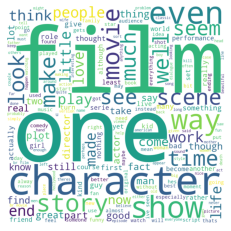

In [58]:
words = ' '.join(data['review'].values)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(words)
 
plt.imshow(wordcloud)
plt.axis("off")
plt.show()